<div style="text-align: right"><sub>This notebook is distributed under the <a href="https://creativecommons.org/licenses/by-sa/3.0/" target="_blank">Attribution-ShareAlike 3.0 International (CC BY-SA 3.0) license</a>.</sub></div>
<h1>Curs d'Òptica en Python <span style="font-size:10px;"> <i>Jupyter notbooks collection by <a href="https://webgrec.ub.edu/webpages/000004/cat/dmaluenda.ub.edu.html" target="_blank">David Maluenda</a></i></span></h1>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a href="https://campusvirtual.ub.edu/my" target="_blank">
      <img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/ub_logo-01.png" width="130"/>
    </a>
  </td>
  <td>
     &#160 &#160 &#160 &#160 &#160
  </td>
  <td>   <!-- gColab -->
    <a href="https://colab.research.google.com/github/opticaUB/material_classe/blob/main/23_Prop_FresnelCoeff.ipynb" target="_blank">
      <img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/colab_logo_32px.png" />
      Run in Google Colab
    </a>
  </td>
  <td>
     &#160 &#160 &#160 &#160 &#160
  </td>
  <td>   <!-- github -->
    <a href="https://github.com/opticaUB/material_classe/blob/main/23_Prop_FresnelCoeff.ipynb" target="_blank">
      <img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/github_logo_32px.png" />
      View source on GitHub
    </a>
  </td>
  <td>
      &#160 &#160 &#160 &#160 &#160
  </td>
  <td>   <!-- download -->
    <a href="https://raw.githubusercontent.com/opticaUB/material_classe/main/23_Prop_FresnelCoeff.ipynb"  target="_blank"
          download="02_Training">
      <img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/download_logo_32px.png" />
      Download notebook
      </a>
  </td>
</table>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import time
from IPython.display import clear_output

Definim els eixos $XZ$ pel pla d'incidència. Addicionalment, definim unes màscares (de valor $0$ o $1$) d'on s'ha de calcular els camps incidents, reflectit i transmés.

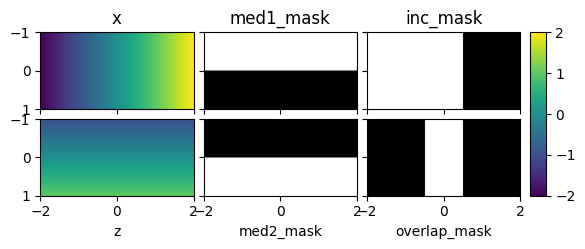

In [2]:
def get_coords(overlap=0.5, verbose=False):

    N_points = 300
    rang = np.linspace(-1, 1, N_points)
    x, z = np.meshgrid(rang, rang)
    x = 2*x
    
    inc_mask = (x<overlap)
    refl_mask = (x>-overlap)
    med1_mask = z<0
    med2_mask = z>0

    if verbose:
        fig = plt.figure(figsize=(30,15))
        axs = ImageGrid(fig, 142,
                         nrows_ncols=(2, 3), axes_pad=0.1, label_mode="L", share_all=True,
                         cbar_location="right", cbar_mode="single")
        
        im = axs[0].imshow(x, extent=[-2,2,1,-1], vmin=-2, vmax=2)
        axs[0].set_title("x")
        
        axs[1].imshow(med1_mask, extent=[-2,2,1,-1], cmap='gray')
        axs[1].set_title("med1_mask")

        axs[2].imshow(inc_mask, extent=[-2,2,1,-1], cmap='gray')
        axs[2].set_title("inc_mask")
        
        axs[3].imshow(z, extent=[-2,2,1,-1], vmin=-2, vmax=2)
        axs[3].set_xlabel("z")
        
        axs[4].imshow(med2_mask, extent=[-2,2,1,-1], cmap='gray')
        axs[4].set_xlabel("med2_mask")

        axs[5].imshow(inc_mask*refl_mask, extent=[-2,2,1,-1], cmap='gray')
        axs[5].set_xlabel("overlap_mask")
        
        axs.cbar_axes[0].colorbar(im)

    return x, z, inc_mask*med1_mask, med2_mask, refl_mask*med1_mask

_ = get_coords(0.5, True)

In [17]:
def main(wavelen0, theta1_d, n1, n2, k2, mode, overlap, maxim):

    #%% Basic parameters %%
    c = 1  # vacum velocity 1 micron per time step
    k0 = 2 * np.pi / wavelen0  # vacum wavenumber in microns^-1
    theta1 = np.radians(theta1_d)
    sin_theta1 = np.sin(theta1) 
    cos_theta1 = np.cos(theta1)
    omega = c*k0  # w = ck

    # theta2 and its trigonometrics
    n2_hat = n2 - 1j*k2  # complex refractive index
    sin_theta2 = n1 * sin_theta1 / n2_hat
    theta2 = np.arcsin(sin_theta2)
    cos_theta2 = np.cos(theta2)
    
    # Fresnel coeff.
    ts = 2*np.cos(theta1)*np.sin(theta2) / np.sin(theta2+theta1)
    tp = ts / np.cos(theta2-theta1)
    
    rs = np.sin(theta2-theta1) / np.sin(theta2+theta1)
    rp = np.tan(theta2-theta1) / np.tan(theta2+theta1)
    
    r = rp if mode=="p" else rs
    t = tp if mode=="p" else ts

    # coords and plotting masks
    x, z, inc_mask, trans_mask, refl_mask = get_coords(overlap)

    #%% Stationary waves %%
    Amp_inc = 1
    prop_inc = np.exp(-1j*k0*n1*(x*sin_theta1+z*cos_theta1))
    
    Amp_refl = r * Amp_inc
    prop_refl = np.exp(-1j*k0*n1*(x*sin_theta1-z*cos_theta1))
    
    Amp_trans = t * Amp_inc
    prop_trans = np.exp(-1j*k0*n2_hat*(x*sin_theta2+z*cos_theta2))
      
    Delta_t = 100
    for clock in range(Delta_t):
        clear_output(wait=True)
        osci_term = np.exp(-1j*omega*clock)  # t is already defined for trans coeff, using clock
        
        E_inc = Amp_inc * prop_inc * osci_term * inc_mask
        E_refl = Amp_refl * prop_refl * osci_term * refl_mask
        E_trans = Amp_trans * prop_trans * osci_term * trans_mask
        
        E_tot = E_inc + E_trans + E_refl
    
        maxim_ = maxim or np.real(E_tot.max())
        plt.figure(figsize=(15,7))
        plt.imshow(np.real(E_tot), vmin=-maxim_, vmax=maxim_, cmap='RdBu', extent=[-2,2,-1,1])
        plt.plot([-2.1, 2.1], [0, 0], '-k', linewidth=3)  # interface line
        plt.axis('off')
        plt.axis('equal')
        plt.colorbar()
        plt.show()

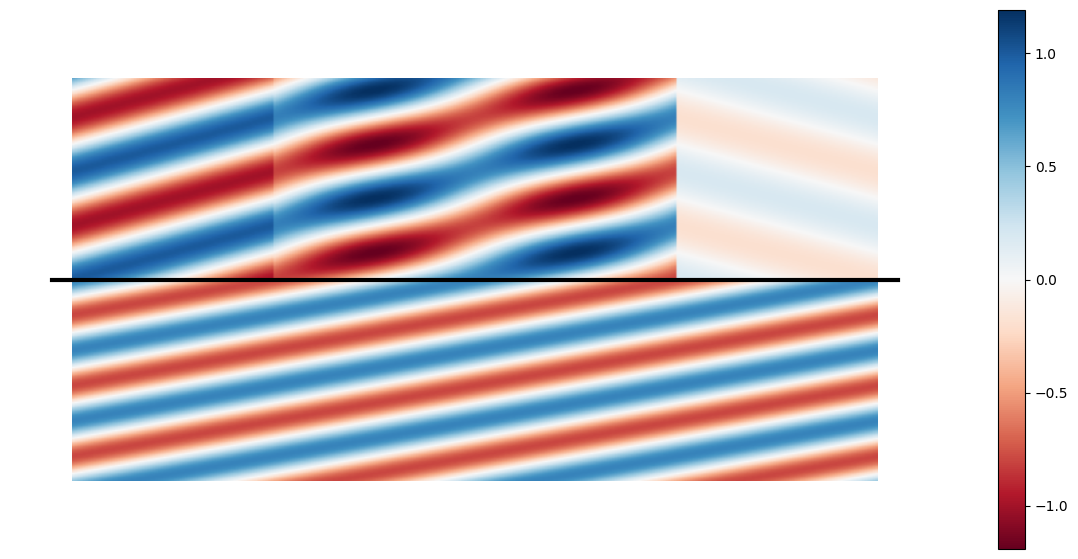

In [19]:
wavelen0 = 0.520  # microns wavelength

n1 = 1        # first media refracting index
mode = "p"  # choose "s" or "p"

n2 = 1.5      # second media refracting index
k2 = 0         # second media extintion index

theta1_d = 15  #  np.degrees(np.arctan(n2/n1))-10  #  np.degrees(np.arcsin(n2/n1))+0.1    # degrees

maxim = None
overlap = 1

main(wavelen0, theta1_d, n1, n2, k2, mode, overlap, maxim)